In [1]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from xgboost import XGBClassifier

import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import   OneHotEncoder, StandardScaler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_all_20_21 = pd.read_csv("/content/drive/MyDrive/TFM/datos/df_all_20_21.csv", sep = ";")

In [5]:
df_all_20_21 = df_all_20_21.sort_values(by='fecha')
df_all_20_21.set_index('fecha', inplace=True)

In [6]:
df_all_20_21.columns

Index(['indicativo', 'prec', 'tmax', 'tmed', 'tmin', 'velmedia', 'racha',
       'sol', 'presMax', 'presMin', 'rhum', 'altitud',
       'porcentaje_pendiente_total', 'alto_riesgo', 'peligro', 'vulner',
       'ocurrencia', 'municipio', 'cod_municipio', 'total_viajes_estacion',
       'total_viajes_km_estacion', 'laborable', 'dayofyear', 'weekend', 'mes'],
      dtype='object')

In [7]:
df_all_20_21 = df_all_20_21.drop(['indicativo', 'municipio', 'cod_municipio', 'total_viajes_km_estacion'], axis=1)
df_all_20_21.head()

,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,rhum,...,porcentaje_pendiente_total,alto_riesgo,peligro,vulner,ocurrencia,total_viajes_estacion,laborable,dayofyear,weekend,mes
fecha,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.0,12.4,12.1,11.9,0.3,8.3,457.0,1020.7,1020.1,63.0,...,2.50,Sí,Molt Alt,Molt Alta,0,0.0,3,1,0,1
2015-01-01,0.0,12.0,11.6,10.8,0.8,1.8,437.0,1034.6,1034.4,55.0,...,2.50,Sí,Molt Alt,Moderada,0,0.0,3,1,0,1
2015-01-01,0.0,13.5,6.2,-1.1,1.9,7.2,7.3,1027.2,1021.7,63.0,...,2.50,Sí,Exclos,Moderada,0,0.0,3,1,0,1
2015-01-01,0.0,11.7,4.2,-3.3,1.1,6.1,7.4,1001.5,996.5,60.0,...,3.22,Sí,Alt,Mitja,0,0.0,3,1,0,1
2015-01-01,0.0,14.2,10.3,6.4,2.5,13.3,429.0,1034.6,1034.4,68.0,...,5.10,Sí,Molt Alt,Moderada,0,0.0,3,1,0,1


In [8]:
df_all_20_21 = df_all_20_21.loc['2020-02-21':'2021-05-09'] 

In [9]:
df_all_20_21.groupby("ocurrencia").count()

,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,rhum,altitud,porcentaje_pendiente_total,alto_riesgo,peligro,vulner,total_viajes_estacion,laborable,dayofyear,weekend,mes
ocurrencia,,,,,,,,,,,,,,,,,,,,
0,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133
1,382,382,382,382,382,382,382,382,382,382,382,382,382,382,382,382,382,382,382,382


In [10]:
df_all_20_21.groupby("ocurrencia").count().columns

Index(['prec', 'tmax', 'tmed', 'tmin', 'velmedia', 'racha', 'sol', 'presMax',
       'presMin', 'rhum', 'altitud', 'porcentaje_pendiente_total',
       'alto_riesgo', 'peligro', 'vulner', 'total_viajes_estacion',
       'laborable', 'dayofyear', 'weekend', 'mes'],
      dtype='object')

In [11]:
df_ocurrencia_0 = df_all_20_21[df_all_20_21["ocurrencia"]==0].sample(382)

In [12]:
df_ocurrencia_1 = df_all_20_21[df_all_20_21["ocurrencia"]==1]

In [13]:
df_all_20_21_rus =  pd.concat([df_ocurrencia_0, df_ocurrencia_1])
df_all_20_21_rus.shape

(764, 21)

In [14]:
X = df_all_20_21_rus.drop( ['ocurrencia'], axis=1)
y = df_all_20_21_rus['ocurrencia']

In [15]:
# Utilizando random para genera números aleatorios.
import random
random.seed(123)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
df_all_20_21_rus.shape,  X_train.shape, y_train.shape, X_test.shape, y_test.shape

((764, 21), (611, 20), (611,), (153, 20), (153,))

#Normalizacion de datos

In [17]:
# normalizacion de los datos numericos
numericalCols_train = X_train[["prec","tmed","velmedia","sol","presMax","rhum", "altitud", "porcentaje_pendiente_total", 'total_viajes_estacion']]
numericalCols_test = X_test[["prec","tmed","velmedia","sol","presMax","rhum", "altitud", "porcentaje_pendiente_total", 'total_viajes_estacion']]

scaler = StandardScaler()
scaler.fit(numericalCols_train)

numericalCols_train_scaled = scaler.transform(numericalCols_train)
numericalCols_test_scaled = scaler.transform(numericalCols_test)

numericalCols_train_scaled.shape , numericalCols_test_scaled.shape

((611, 9), (153, 9))

In [18]:
# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_train = X_train[["alto_riesgo" ,	"peligro" ,	"vulner"]]  #alto_riesgo	peligro	vulner
categoricalCols_train = OneHotEncoder().fit_transform(categoricalCols_train).toarray()


# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_test = X_test[["alto_riesgo" ,	"peligro" ,	"vulner"]]   #alto_riesgo	peligro	 y vulner
categoricalCols_test = OneHotEncoder().fit_transform(categoricalCols_test).toarray()

categoricalCols_train.shape, categoricalCols_test.shape

((611, 12), (153, 12))

In [19]:
Other_var_train = X_train[['laborable', 	'dayofyear', 	'weekend', 	'mes']]
Other_var_test = X_test[['laborable', 	'dayofyear', 	'weekend', 	'mes']]  #alto_riesgo	peligro	 y vulner

In [20]:
df_train_scaled = np.concatenate((numericalCols_train_scaled , categoricalCols_train, Other_var_train), axis=1)
df_test_scaled = np.concatenate((numericalCols_test_scaled , categoricalCols_test, Other_var_test), axis=1)

In [21]:
df_train_scaled.shape, y_train.shape, df_test_scaled.shape, y_test.shape

((611, 25), (611,), (153, 25), (153,))

In [22]:
X_test = df_test_scaled
X_train = df_train_scaled

#Model xgboost

In [23]:
model_xgb = XGBClassifier(n_estimators= 1500, 
                      learning_rate=0.0001,
                      objective= 'binary:logistic',
                      random_state=0,
                      n_jobs=-1, 
                      max_depth=20, verbose=3)

In [24]:
model_xgb.fit(X_train, y_train)

XGBClassifier(learning_rate=0.0001, max_depth=20, n_estimators=1500, n_jobs=-1,
              verbose=3)

In [25]:
y_pred = model_xgb.predict(X_test)

In [26]:
accuracy_score(y_test, y_pred)

0.5555555555555556

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Conjunto de datos de validación
  Exactitud:     0.55556
  Precisión:     0.54995
  Exhaustividad: 0.55024
              precision    recall  f1-score   support

           0       0.49      0.51      0.50        67
           1       0.61      0.59      0.60        86

    accuracy                           0.56       153
   macro avg       0.55      0.55      0.55       153
weighted avg       0.56      0.56      0.56       153



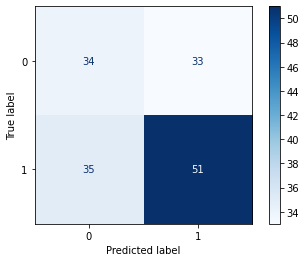

In [27]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(model_xgb, X_test, y_test, cmap = plt.cm.Blues)

print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

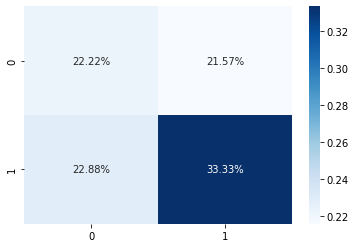

In [28]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

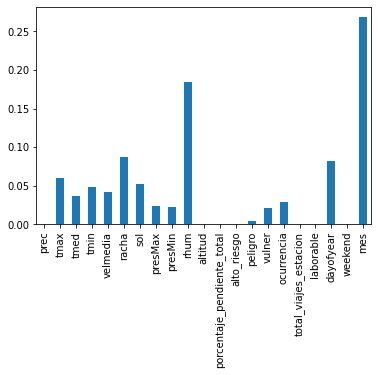

In [29]:
importances = model_xgb.feature_importances_
importances_dict = dict(zip(df_all_20_21.columns, importances))
pd.Series(importances_dict).plot(kind='bar')

#Grid Model XGBoost

In [30]:
param_grid = {
    'n_estimators': [1500],
    'max_depth' : [5, 10],
    'min_samples_split' : [5, 10],
    'min_samples_leaf' : [5, 10],
    'class_weight':[{0: 1, 1: 1}, {0: 1, 1: 50}]
}

In [31]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 50}],
                         'max_depth': [5, 10], 'min_samples_leaf': [5, 10],
                         'min_samples_split': [5, 10], 'n_estimators': [1500]},
             verbose=True)

In [32]:
final_model = grid_search.best_estimator_
final_model

XGBClassifier(class_weight={0: 1, 1: 1}, max_depth=5, min_samples_leaf=5,
              min_samples_split=5, n_estimators=1500)

Conjunto de datos de validación
  Exactitud:     0.55556
  Precisión:     0.54995
  Exhaustividad: 0.55024
              precision    recall  f1-score   support

           0       0.49      0.51      0.50        67
           1       0.61      0.59      0.60        86

    accuracy                           0.56       153
   macro avg       0.55      0.55      0.55       153
weighted avg       0.56      0.56      0.56       153



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


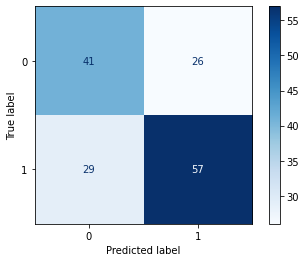

In [33]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(final_model, X_test, y_test, cmap = plt.cm.Blues)

print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

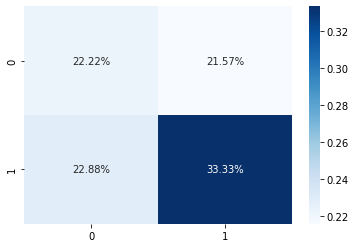

In [34]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

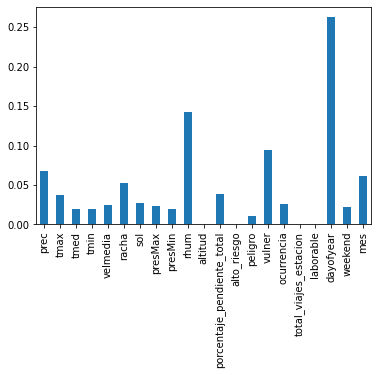

In [35]:
importances_final = final_model.feature_importances_
importances_dict_final = dict(zip(df_all_20_21.columns, importances_final))
pd.Series(importances_dict_final).plot(kind='bar')

#Balanceo de clases con SMOTE


In [36]:
from imblearn.over_sampling import SMOTE 
X_smote , y_smote = SMOTE().fit_resample(X_train, y_train)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_smote.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_smote.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_smote == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_smote == 0)))


Before OverSampling, counts of label '1': 296
Before OverSampling, counts of label '0': 315 

After OverSampling, the shape of train_X: (630, 25)
After OverSampling, the shape of train_y: (630,) 

After OverSampling, counts of label '1': 315
After OverSampling, counts of label '0': 315


In [37]:
model_smote = XGBClassifier(n_estimators= 1500, 
                      learning_rate=0.0001,
                      objective= 'binary:logistic',
                      random_state=0,
                      n_jobs=-1, 
                      max_depth=20, verbose=3)

In [38]:
model_smote.fit(X_smote, y_smote)

XGBClassifier(learning_rate=0.0001, max_depth=20, n_estimators=1500, n_jobs=-1,
              verbose=3)

In [39]:
y_pred = model_smote.predict(X_test)

In [40]:
y_test.sum(), y_pred.sum()

(86, 77)

Conjunto de datos de validación
  Exactitud:     0.64052
  Precisión:     0.64012
  Exhaustividad: 0.64231
              precision    recall  f1-score   support

           0       0.58      0.66      0.62        67
           1       0.70      0.63      0.66        86

    accuracy                           0.64       153
   macro avg       0.64      0.64      0.64       153
weighted avg       0.65      0.64      0.64       153



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


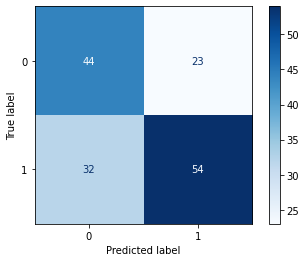

In [41]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(model_smote, X_test, y_test, cmap = plt.cm.Blues)

print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

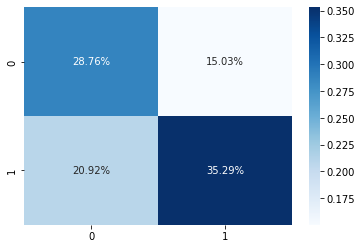

In [42]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

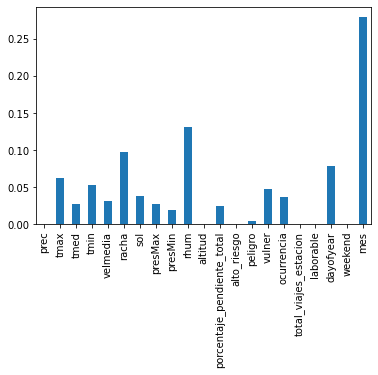

In [43]:
importances_smote = model_smote.feature_importances_
importances_dict_smote = dict(zip(df_all_20_21.columns, importances_smote))
pd.Series(importances_dict_smote).plot(kind='bar')

#Grid Smote

In [44]:
param_grid = {
    'n_estimators': [1500,2500],
    'max_depth' : [5, 10, 15],
    'min_samples_split' : [5, 10, 15],
    'min_samples_leaf' : [5, 10, 15],
    'class_weight':[{0: 1, 1: 1}]
}

In [45]:
from sklearn.model_selection import GridSearchCV

grid_search_smote = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=3, verbose=True)
grid_search_smote.fit(X_smote, y_smote)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3, estimator=XGBClassifier(),
             param_grid={'class_weight': [{0: 1, 1: 1}],
                         'max_depth': [5, 10, 15],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [1500, 2500]},
             verbose=True)

In [46]:
final_model_smote = grid_search_smote.best_estimator_
final_model_smote

XGBClassifier(class_weight={0: 1, 1: 1}, max_depth=10, min_samples_leaf=5,
              min_samples_split=5, n_estimators=2500)

Conjunto de datos de validación
  Exactitud:     0.64052
  Precisión:     0.64012
  Exhaustividad: 0.64231
              precision    recall  f1-score   support

           0       0.58      0.66      0.62        67
           1       0.70      0.63      0.66        86

    accuracy                           0.64       153
   macro avg       0.64      0.64      0.64       153
weighted avg       0.65      0.64      0.64       153



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


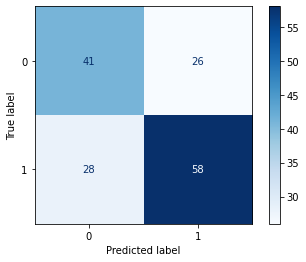

In [47]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(final_model_smote, X_test, y_test, cmap = plt.cm.Blues)

print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

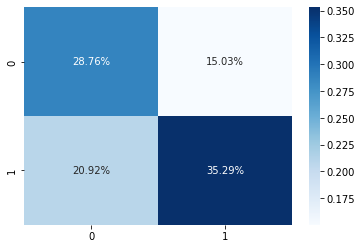

In [48]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

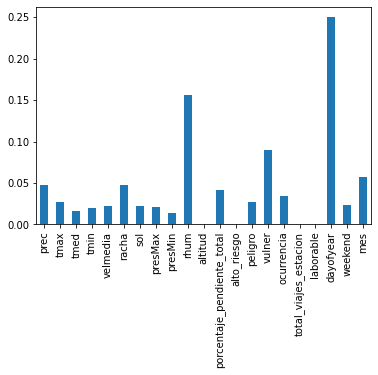

In [49]:
importances_smote_final = final_model_smote.feature_importances_
importances_dict_final_smote = dict(zip(df_all_20_21.columns, importances_smote_final))
pd.Series(importances_dict_final_smote).plot(kind='bar')

#Balanceo de clases RandomUnderSampler


In [50]:
from imblearn.under_sampling import RandomUnderSampler

X_rus , y_rus = RandomUnderSampler().fit_resample(X_train, y_train)


print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After UnderSampling, the shape of train_X: {}'.format(X_rus.shape))
print('After UnderSampling, the shape of train_y: {} \n'.format(y_rus.shape))
  
print("After UnderSampling, counts of label '1': {}".format(sum(y_rus == 1)))
print("After UnderSampling, counts of label '0': {}".format(sum(y_rus == 0)))

Before UnderSampling, counts of label '1': 296
Before UnderSampling, counts of label '0': 315 

After UnderSampling, the shape of train_X: (592, 25)
After UnderSampling, the shape of train_y: (592,) 

After UnderSampling, counts of label '1': 296
After UnderSampling, counts of label '0': 296


In [51]:
model_rus = XGBClassifier(n_estimators= 1500, 
                      learning_rate=0.0001,
                      objective= 'binary:logistic',
                      random_state=0,
                      n_jobs=-1, 
                      max_depth=20, verbose=3)

In [52]:
model_rus.fit(X_rus, y_rus)

XGBClassifier(learning_rate=0.0001, max_depth=20, n_estimators=1500, n_jobs=-1,
              verbose=3)

In [53]:
y_pred = model_rus.predict(X_test)

Conjunto de datos de validación
  Exactitud:     0.58170
  Precisión:     0.57635
  Exhaustividad: 0.57680
              precision    recall  f1-score   support

           0       0.52      0.54      0.53        67
           1       0.63      0.62      0.62        86

    accuracy                           0.58       153
   macro avg       0.58      0.58      0.58       153
weighted avg       0.58      0.58      0.58       153



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


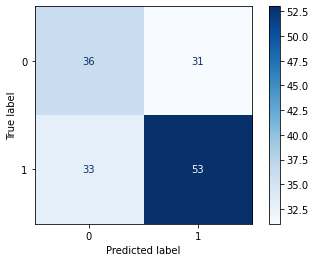

In [54]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(model_rus, X_test, y_test, cmap = plt.cm.Blues)

print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

In [55]:
y_test.sum(), y_pred.sum(), y_train.sum(), y_rus.sum()

(86, 84, 296, 296)

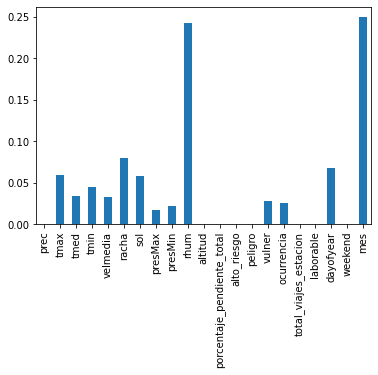

In [56]:
importances_rus = model_rus.feature_importances_
importances_dict_rus = dict(zip(df_all_20_21.columns, importances_rus))
pd.Series(importances_dict_rus).plot(kind='bar')

#Grid RUS

In [57]:
param_grid = {
    'n_estimators': [1500],
    'max_depth' : [5, 10, 15],
    'min_samples_split' : [5, 10,15],
    'min_samples_leaf' : [5, 10,15],
    'class_weight':[{0: 1, 1: 1}, {0: 1, 1: 50}]
}

In [58]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_rus, y_rus)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 50}],
                         'max_depth': [5, 10, 15],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [1500]},
             verbose=True)

In [59]:
final_model_rus = grid_search.best_estimator_
final_model_rus

XGBClassifier(class_weight={0: 1, 1: 1}, max_depth=15, min_samples_leaf=5,
              min_samples_split=5, n_estimators=1500)

Conjunto de datos de validación
  Exactitud:     0.58170
  Precisión:     0.57635
  Exhaustividad: 0.57680
              precision    recall  f1-score   support

           0       0.52      0.54      0.53        67
           1       0.63      0.62      0.62        86

    accuracy                           0.58       153
   macro avg       0.58      0.58      0.58       153
weighted avg       0.58      0.58      0.58       153



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


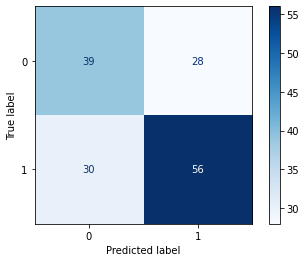

In [60]:
fcm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(final_model_rus, X_test, y_test, cmap = plt.cm.Blues)

print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

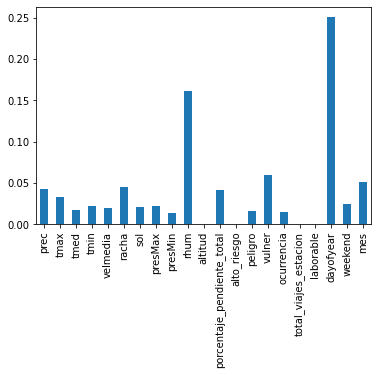

In [61]:
importances_rus_1 = final_model_rus.feature_importances_
importances_dict_rus_1 = dict(zip(df_all_20_21.columns, importances_rus_1))
pd.Series(importances_dict_rus_1).plot(kind='bar')

#Seleccion de variables importantes


In [89]:
df_important_20_21 = df_all_20_21.drop(['sol', 'prec', 'tmed', 'velmedia', 'presMax' , 'porcentaje_pendiente_total','tmin', 'peligro', 'weekend', 'altitud', 'laborable','presMin','vulner', 'alto_riesgo'], axis=1)
df_important_20_21

,tmax,racha,rhum,ocurrencia,total_viajes_estacion,dayofyear,mes
fecha,,,,,,,
2020-02-21,18.3,3.3,66.0,0,131124.58,52,2
2020-02-21,19.1,4.7,53.0,0,76265.91,52,2
2020-02-21,16.3,6.5,68.0,0,73130.00,52,2
2020-02-21,18.4,9.7,68.0,0,3325634.10,52,2
2020-02-21,17.2,9.2,64.0,0,308683.38,52,2
...,...,...,...,...,...,...,...
2021-05-09,4.7,11.0,93.0,0,0.00,129,5
2021-05-09,5.3,5.4,94.0,0,88213.92,129,5
2021-05-09,23.6,4.9,54.0,0,9931.26,129,5


In [90]:
df_important_20_21.groupby("ocurrencia").count()

,tmax,racha,rhum,total_viajes_estacion,dayofyear,mes
ocurrencia,,,,,,
0,84133,84133,84133,84133,84133,84133
1,382,382,382,382,382,382


In [91]:
df_important_20_21.groupby("ocurrencia").count().columns

Index(['tmax', 'racha', 'rhum', 'total_viajes_estacion', 'dayofyear', 'mes'], dtype='object')

In [93]:
df_ocurrencia_0 = df_important_20_21[df_important_20_21["ocurrencia"]==0].sample(382)

In [94]:
df_ocurrencia_1 = df_important_20_21[df_important_20_21["ocurrencia"]==1]

In [95]:
df_important_20_21 =  pd.concat([df_ocurrencia_0, df_ocurrencia_1])
df_important_20_21.shape
df_important_20_21

,tmax,racha,rhum,ocurrencia,total_viajes_estacion,dayofyear,mes
fecha,,,,,,,
2021-02-14,8.9,5.7,98.0,0,1.667378e+05,45,2
2021-02-06,-2.2,5.7,100.0,0,0.000000e+00,37,2
2020-04-02,13.6,4.1,78.0,0,5.126160e+03,93,4
2020-05-26,25.8,8.6,42.0,0,0.000000e+00,147,5
2021-01-22,11.6,18.5,59.0,0,0.000000e+00,22,1
...,...,...,...,...,...,...,...
2021-05-08,27.8,4.8,43.0,1,1.369186e+05,128,5
2021-05-08,25.5,7.1,51.0,1,0.000000e+00,128,5
2021-05-08,25.5,8.6,47.0,1,5.151843e+05,128,5


In [96]:
X = df_important_20_21.drop( ['ocurrencia'], axis=1)
y = df_important_20_21['ocurrencia']

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [98]:
df_all_20_21.shape,  X_train.shape, y_train.shape, X_test.shape, y_test.shape

((84515, 21), (611, 6), (611,), (153, 6), (153,))

In [99]:
# normalizacion de los datos numericos
numericalCols_train = X_train[['rhum', 'racha', 'tmax','total_viajes_estacion']]
numericalCols_test = X_test[['rhum', 'racha', 'tmax', 'total_viajes_estacion']]

scaler = StandardScaler()
scaler.fit(numericalCols_train)

numericalCols_train_scaled = scaler.transform(numericalCols_train)
numericalCols_test_scaled = scaler.transform(numericalCols_test)

numericalCols_train_scaled.shape , numericalCols_test_scaled.shape

((611, 4), (153, 4))

In [72]:
# # normalizacion de los datos categoricos , sin la ocurrencia
# categoricalCols_train = X_train[[	'vulner']]  #alto_riesgo	peligro	vulner
# categoricalCols_train = OneHotEncoder().fit_transform(categoricalCols_train).toarray()


# # normalizacion de los datos categoricos , sin la ocurrencia
# categoricalCols_test = X_test[['vulner']]   #alto_riesgo	peligro	 y vulner
# categoricalCols_test = OneHotEncoder().fit_transform(categoricalCols_test).toarray()

# categoricalCols_train.shape, categoricalCols_test.shape

In [100]:
Other_var_train = X_train[['dayofyear',	'mes']]
Other_var_test = X_test[['dayofyear',	'mes']]  #alto_riesgo	peligro	 y vulner

In [101]:
df_train_scaled = np.concatenate((numericalCols_train_scaled ,  Other_var_train), axis=1)
df_test_scaled = np.concatenate((numericalCols_test_scaled ,  Other_var_test), axis=1)

In [102]:
df_train_scaled.shape, y_train.shape, df_test_scaled.shape, y_test.shape

((611, 6), (611,), (153, 6), (153,))

In [103]:
X_test = df_test_scaled
X_train = df_train_scaled

In [104]:
model_importances = XGBClassifier(n_estimators= 1500, 
                      learning_rate=0.0001,
                      objective= 'binary:logistic',
                      random_state=0,
                      n_jobs=-1, 
                      max_depth=20, verbose=3)

In [105]:
model_importances.fit(X_train, y_train)

XGBClassifier(learning_rate=0.0001, max_depth=20, n_estimators=1500, n_jobs=-1,
              verbose=3)

In [106]:
y_pred = model_importances.predict(X_test)

In [107]:
accuracy_score(y_test, y_pred)

0.5882352941176471

Conjunto de datos de validación
  Exactitud:     0.58824
  Precisión:     0.59404
  Exhaustividad: 0.59259
              precision    recall  f1-score   support

           0       0.55      0.67      0.60        72
           1       0.64      0.52      0.57        81

    accuracy                           0.59       153
   macro avg       0.59      0.59      0.59       153
weighted avg       0.60      0.59      0.59       153



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


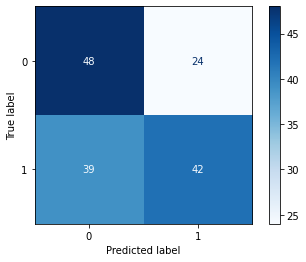

In [108]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(model_importances, X_test, y_test, cmap = plt.cm.Blues)

print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

In [ ]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

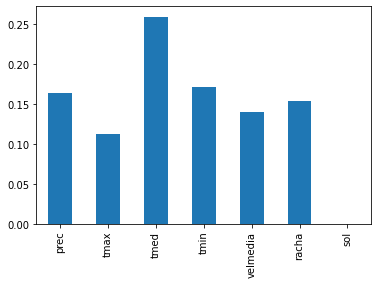

In [83]:
importances_1 = model_importances.feature_importances_
importances_dict_1 = dict(zip(df_all_20_21.columns, importances_1))
pd.Series(importances_dict_1).plot(kind='bar')

#Grid Variables Importantes

In [109]:
param_grid = {
    'n_estimators': [1500],
    'max_depth' : [5, 10, 15],
    'min_samples_split' : [5, 10,15],
    'min_samples_leaf' : [5, 10,15],
    'class_weight':[{0: 1, 1: 1}, {0: 1, 1: 50}]
}

In [110]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 50}],
                         'max_depth': [5, 10, 15],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [1500]},
             verbose=True)

In [111]:
final_model_import= grid_search.best_estimator_
final_model_import

XGBClassifier(class_weight={0: 1, 1: 1}, max_depth=15, min_samples_leaf=5,
              min_samples_split=5, n_estimators=1500)

Conjunto de datos de validación
  Exactitud:     0.58824
  Precisión:     0.59404
  Exhaustividad: 0.59259
              precision    recall  f1-score   support

           0       0.55      0.67      0.60        72
           1       0.64      0.52      0.57        81

    accuracy                           0.59       153
   macro avg       0.59      0.59      0.59       153
weighted avg       0.60      0.59      0.59       153



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


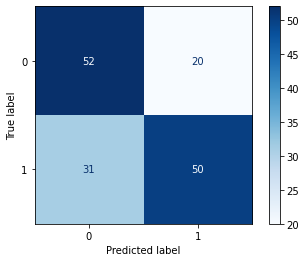

In [112]:
fcm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(final_model_import, X_test, y_test, cmap = plt.cm.Blues)

print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

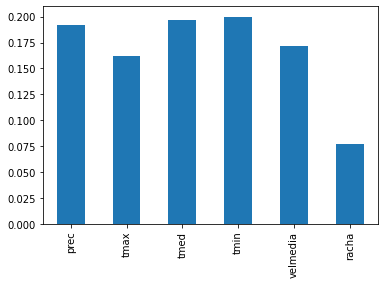

In [113]:
importances_import = final_model_import.feature_importances_
importances_dict_import = dict(zip(df_all_20_21.columns, importances_import))
pd.Series(importances_dict_import).plot(kind='bar')